![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive



In [41]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
from tensorflow import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers,layers, models, initializers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Incorporarla carpeta de Google Drive para poder "guardar"  modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [42]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Arquitectura de red del modelo


In [ ]:
# Crear una red que será extracción de features basada en DenseNet121 entrenada con ImageNet (224x224x3)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [44]:
output = base_model.layers[-1].output
output

<KerasTensor shape=(None, 7, 7, 1024), dtype=float32, sparse=False, name=keras_tensor_921>

In [45]:
output_layer = ks.layers.Flatten()(output)
output_layer

<KerasTensor shape=(None, 50176), dtype=float32, sparse=False, name=keras_tensor_922>

In [46]:
model_prebase= Model(base_model.input, output_layer)
model_prebase.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [47]:
# Veamos como va lo de "congelar" capas de entrenamiento

pd.set_option("display.max_colwidth", True)

In [48]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prebase.layers]

In [49]:
pd.DataFrame(layers, columns=["Layer", "Name", "Is trainable?"])

,Layer,Name,Is trainable?
0,"<InputLayer name=input_layer_2, built=True>",input_layer_2,True
1,"<ZeroPadding2D name=zero_padding2d_2, built=True>",zero_padding2d_2,True
2,"<Conv2D name=conv1_conv, built=True>",conv1_conv,True
3,"<BatchNormalization name=conv1_bn, built=True>",conv1_bn,True
4,"<Activation name=conv1_relu, built=True>",conv1_relu,True
...,...,...,...
423,"<Conv2D name=conv5_block16_2_conv, built=True>",conv5_block16_2_conv,True
424,"<Concatenate name=conv5_block16_concat, built=True>",conv5_block16_concat,True
425,"<BatchNormalization name=bn, built=True>",bn,True
426,"<Activation name=relu, built=True>",relu,True


In [50]:
model_prebase.trainable

True

In [ ]:
trainable = False

# Iterar por la cantidad de capas y poner trainable a False
for layer in model_prebase.layers:
    layer.trainable = trainable

# Then, iterate through the last 30 layers of base_model and set trainable to True
for layer in model_prebase.layers[-30:]:
    layer.trainable = True



In [52]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prebase.layers]
pd.DataFrame(layers, columns=["Layer", "Name", "Is trainable?"])

,Layer,Name,Is trainable?
0,"<InputLayer name=input_layer_2, built=True>",input_layer_2,False
1,"<ZeroPadding2D name=zero_padding2d_2, built=True>",zero_padding2d_2,False
2,"<Conv2D name=conv1_conv, built=True>",conv1_conv,False
3,"<BatchNormalization name=conv1_bn, built=True>",conv1_bn,False
4,"<Activation name=conv1_relu, built=True>",conv1_relu,False
...,...,...,...
423,"<Conv2D name=conv5_block16_2_conv, built=True>",conv5_block16_2_conv,True
424,"<Concatenate name=conv5_block16_concat, built=True>",conv5_block16_concat,True
425,"<BatchNormalization name=bn, built=True>",bn,True
426,"<Activation name=relu, built=True>",relu,True


In [53]:
model_prebase.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 639,616 (2.44 MB)

 Non-trainable params: 6,397,888 (24.41 MB)

# Montemos la red de clasificación (Suma de VGG16 + Clasificación)

In [ ]:


model_post = ks.Sequential()
# Definir la capa de entrada con la forma de las imágenes de CIFAR-10
model_post.add(ks.layers.InputLayer(input_shape=(32,32,3),))

# Agregar una capa de redimensionamiento para cambiar el tamaño a (224, 224, 3)
model_post.add(ks.layers.Resizing(224,224,interpolation="bilinear"))

# Agregar model_prebase
model_post.add(model_prebase)

#Red de classificacion
# Capas de clasificación
# Primera capa
model_post.add(ks.layers.Dense(256, kernel_initializer=initializers.HeUniform(),kernel_regularizer=regularizers.l2(1e-4)))
model_post.add(ks.layers.BatchNormalization())
model_post.add(ks.layers.ReLU())
model_post.add(ks.layers.Dropout(0.4))
# Segunda capa
model_post.add(ks.layers.Dense(128, kernel_initializer=initializers.HeUniform(),kernel_regularizer=regularizers.l2(1e-4)))
model_post.add(ks.layers.BatchNormalization())
model_post.add(ks.layers.ReLU())
model_post.add(ks.layers.Dropout(0.4))

# Capa de salida
model_post.add(ks.layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [55]:
model_post.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 50176)               │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,918,538 (75.98 MB)

 Trainable params: 13,519,882 (51.57 MB)

 Non-trainable params: 6,398,656 (24.41 MB)

## 3. Optimizador, función error


In [ ]:
model_post.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [57]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train, x_test / 255.0

In [58]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [59]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


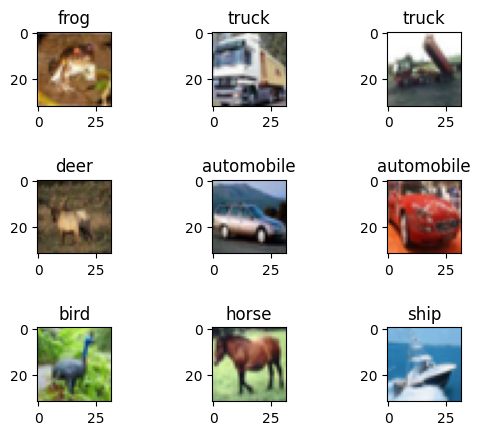

In [60]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [61]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [62]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


# Data augmentation

In [63]:
# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2
# )
# datagen.fit(x_traint)


In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [65]:
# generación de imagenes distorsionadas
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.2),
    rescale=1./255,
)
train_generator = train_datagen.flow(
    x_train_scaled,
    y_train,
    batch_size=128
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = validation_datagen.flow(
    x_val_scaled,
    y_val,
    batch_size=128
)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

### 5.1 Callback for Early Stopping

In [66]:
callback_val_loss=EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=30, restore_best_weights=True)

In [67]:
t = time.perf_counter()

In [68]:
epochs=500

In [69]:
history = model_post.fit(train_generator, epochs=epochs, validation_data=validation_generator,
    steps_per_epoch=200,validation_steps=200, callbacks=[callback_val_loss, callback_val_accuracy])


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2295 - loss: 2.4120

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 122s 480ms/step - accuracy: 0.2299 - loss: 2.4104 - val_accuracy: 0.6666 - val_loss: 1.1697
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.4921 - loss: 1.5714 - val_accuracy: 0.7160 - val_loss: 1.0122
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 372ms/step - accuracy: 0.5605 - loss: 1.4154 - val_accuracy: 0.7560 - val_loss: 0.8715
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.6177 - loss: 1.2625 - val_accuracy: 0.7698 - val_loss: 0.8265
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 371ms/step - accuracy: 0.6388 - loss: 1.1975 - val_accuracy: 0.7921 - val_loss: 0.7659
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.6629 - loss: 1.1131 - val_accuracy: 0.7995 - val_loss: 0.7354
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 370ms/step - accuracy: 0.6816 - loss: 1.0704 - val_accuracy: 0.8108 - val_loss: 0.6914
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - accuracy: 0.6936 - loss: 1.03

In [70]:
# history = model_post_vgg.fit(x=x_train_scaled, y=y_train, batch_size=128,
#                              epochs=epochs, callbacks=[callback_val_loss, callback_val_accuracy],
#                              validation_data=(x_val_scaled, y_val))

In [71]:
#history = model.fit(x_train_scaled, y_train, epochs=epochs,
#                    batch_size= 512,callbacks=[callback_val_loss, callback_val_accuracy],validation_data=(x_val_scaled, y_val))

In [72]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 2:59:13.167598


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

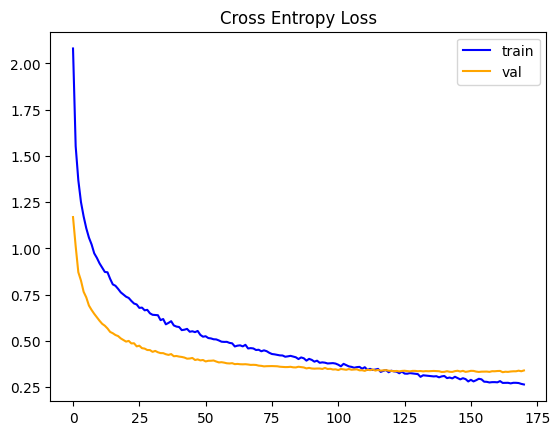

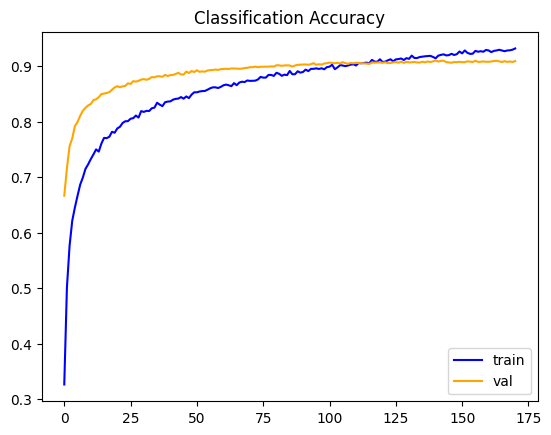

In [73]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

In [74]:
_, acc = model_post.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 90.370


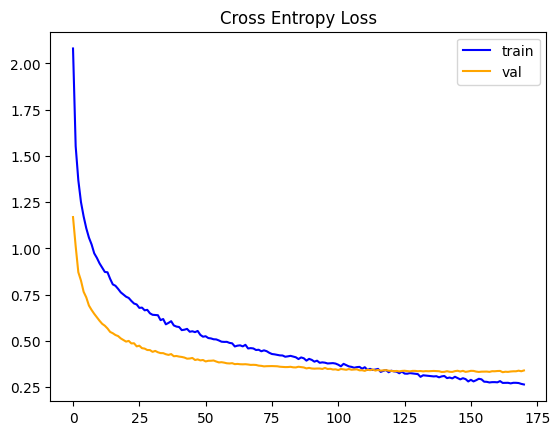

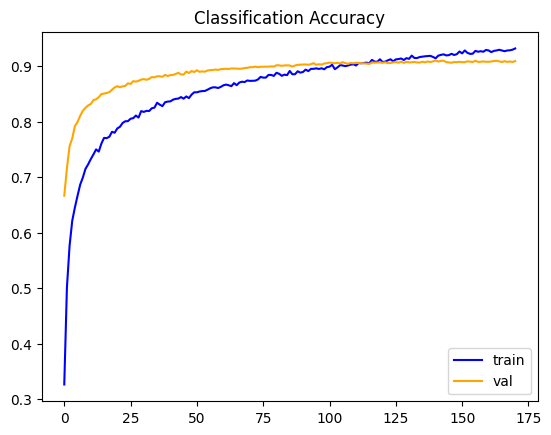

In [75]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [76]:
predictions = model_post.predict(x_test_scaled)

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [77]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


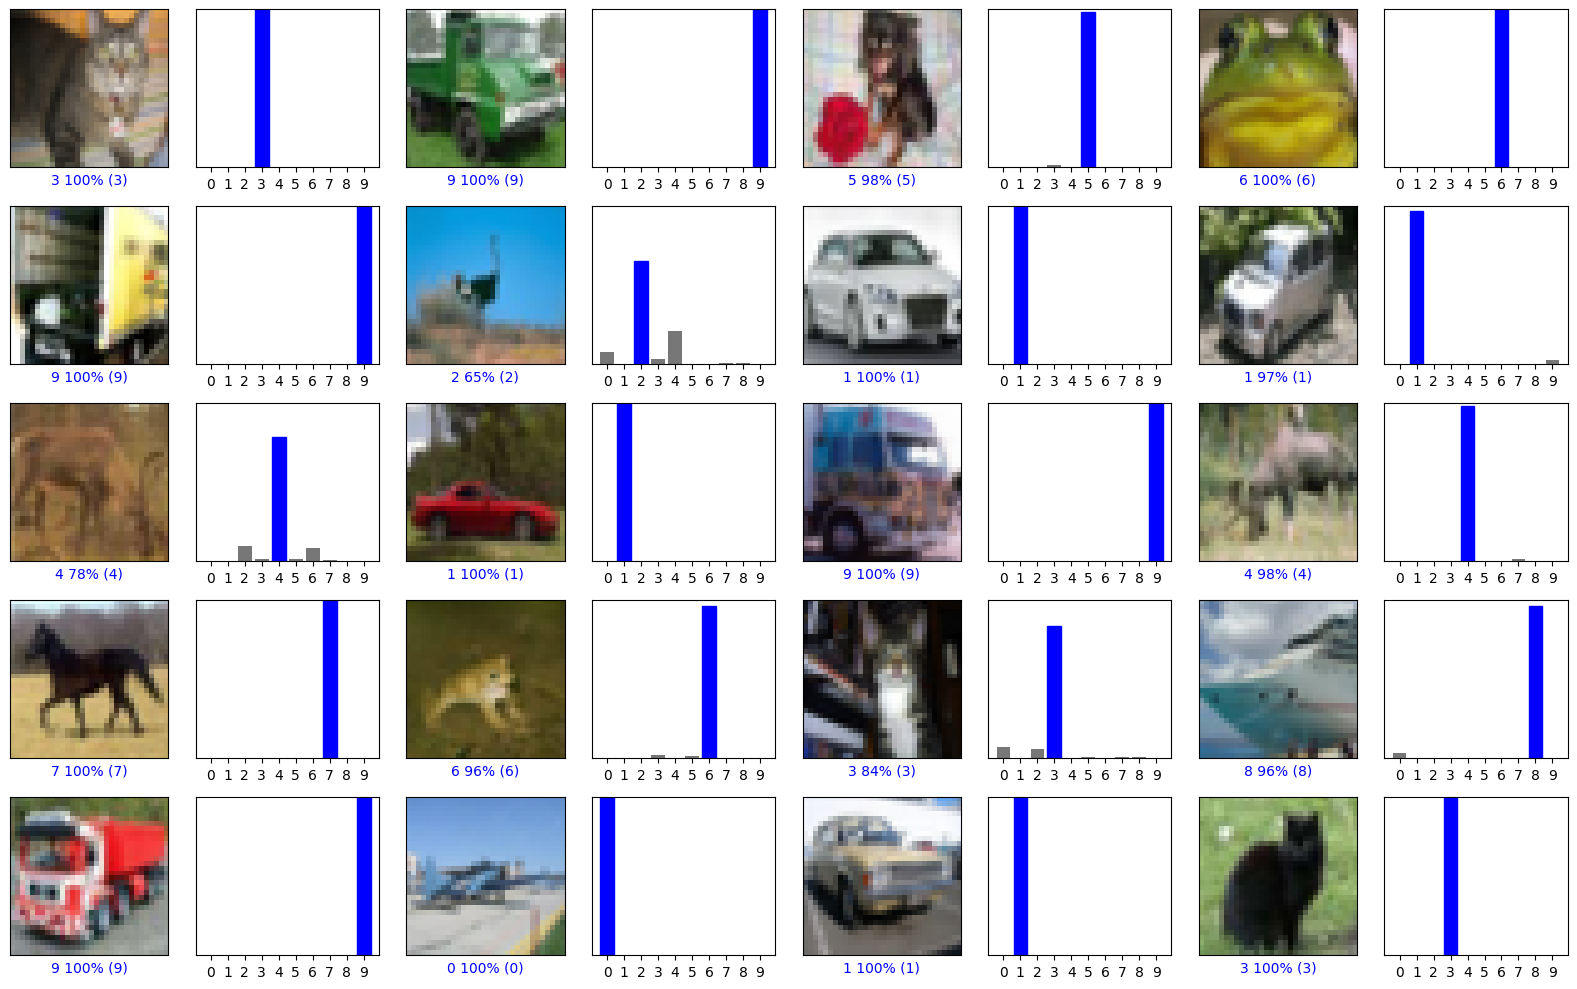

In [78]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [79]:
ruta_googledrive = "/content/drive/MyDrive/" # A revisar en vuestra instancia

model_post.save(ruta_googledrive+'cifar10_base_model_m3FTDA.keras')